In [2]:
# Python 3.7
# Acknoledgment for Harshvardhan Gupta.
# Some work(data loading and sub-network structure) are based on "Facial-Similarity-with-Siamese-Networks-in-Pytorch"
# Which is avalable at: https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [ ]:
#pre-processing
# input: put CUHK01 dataset under data file: ./data/CUHK01
# output: training_set (./data/training_set) and test_set (./data/test_set)
 
import os
import difflib
import shutil

file_dir = "./data/CUHK01/campus"
save_train_dir = "./data/training_set"
save_test_dir = "./data/test_set"

def order(file_list,file_dir_list):
    file_dict = {}
    for parent, _, filenames in os.walk(file_dir):
        for filename in filenames:
            file_dict[filename] = os.path.join(parent, filename)
    return sorted(file_dict.items(),key = lambda x:x[0], reverse = False)            

def move_file(dict):
    index = 0
    dict_len = len(dict)
    while index < (dict_len-3):
        if index <= 870*4:#Keep 100 persons' images in test_set
            save_dir = save_train_dir
        else:
            save_dir = save_test_dir
        
        pic1_root = dict[index][1]        
        pic2_root = dict[index+1][1]          
        pic3_root = dict[index+2][1]          
        pic4_root = dict[index+3][1]
        
        save_doc_name = str(index//4)
        save_doc_root = os.path.join(save_dir, save_doc_name)
        if not os.path.exists(save_doc_root):
            os.makedirs(save_doc_root) 
            
        shutil.copy(pic1_root,save_doc_root) 
        shutil.copy(pic2_root,save_doc_root)
        shutil.copy(pic3_root,save_doc_root)
        shutil.copy(pic4_root,save_doc_root)        
        index += 4

if __name__=='__main__':
    file_list=[]
    file_dir_list=[]
    file_dict=order(file_list,file_dir_list)
    move_file(file_dict)

In [3]:

def normalize(data):
    m = np.mean(data)
    mx = max(data)
    mn = min(data)
    return np.array([[(i - m)/(mx - mn) for i in data]])

In [4]:

class Config():
    training_dir = "./data/training_set/"
    testing_dir = "./data/test_set/"
    reid_prepare_dir = "./data/reid_prepare/"
    train_batch_size = 140
    train_number_epochs = 100

In [5]:


#define the structure of Siamese Network input data in the return of "__getitem__"
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)#imgs has the form like [('./person_i/xxx.jpg',label_i),...]
        
        #50% take the same class.
        take_same_person = random.randint(0,1)
        if take_same_person:
            random_choice = random.randint(0,2)#all people have 4 pictures, so we take 1 of the left 3 for the same person.
            for i in range(len(self.imageFolderDataset.imgs)):
                if self.imageFolderDataset.imgs[i][1]==img0_tuple[1] and self.imageFolderDataset.imgs[i][0]!=img0_tuple[0]:
                    if random_choice!=0:
                        random_choice -= 1
                        continue
                    else:
                        img1_tuple = self.imageFolderDataset.imgs[i]
                        break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        #global HSV feature
        img0_hsv = img0.convert('HSV')
        img1_hsv = img1.convert('HSV')
        
        #local Laplacian texture feature
        img0_grad = cv2.imread(img0_tuple[0])
        img0_grad = cv2.Laplacian(img0_grad,cv2.CV_16S,ksize = 3)
        img0_grad = cv2.convertScaleAbs(img0_grad)#absolute value
        img0_grad = Image.fromarray(img0_grad.astype('uint8')).convert('RGB')
        img1_grad = cv2.imread(img1_tuple[0])
        img1_grad = cv2.Laplacian(img1_grad,cv2.CV_16S,ksize = 3)
        img1_grad = cv2.convertScaleAbs(img1_grad)
        img1_grad = Image.fromarray(img1_grad.astype('uint8')).convert('RGB')
        
        #tranform photos' size
        if self.transform is not None:
            img0_hsv = self.transform(img0_hsv)
            img1_hsv = self.transform(img1_hsv)
            img0_grad = self.transform(img0_grad)
            img1_grad = self.transform(img1_grad)
        
        #label == 0 means img0 & img1 belong to the same person
        label = torch.from_numpy(np.array([int(img0_tuple[1]!=img1_tuple[1])],dtype=np.float32))
        return img0_hsv, img1_hsv, img0_grad, img1_grad, label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:

#a simple CNN with 3 convolutional layers and 3 fully connected layers
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 12, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(12, 24, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(24),

            nn.ReflectionPad2d(1),
            nn.Conv2d(24, 24, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(24),
        )

        self.fc = nn.Sequential(
            nn.Linear(24*160*60, 1000),
            nn.ReLU(inplace=True),

            nn.Linear(1000, 1000),
            nn.ReLU(inplace=True),

            nn.Linear(1000, 18),
        )

    def forward(self, input0, input1):
        
        output0 = self.cnn(input0)#batch_size * depth * width * height
        output0 = output0.view(output0.size()[0], -1)#(batch_size) * (depth * width * height)
        output0 = self.fc(output0)
        
        output1 = self.cnn(input1)
        output1 = output1.view(output1.size()[0], -1)
        output1 = self.fc(output1)
        
        return output0, output1

In [7]:


#loss function
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=3.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    #L=(1-Y)(D^2)+Y*exp(max(margin-distance,0)), Y=0 means the same person
    def forward(self, output0, output1, label):
        euclidean_distance = F.pairwise_distance(output0, output1, keepdim = True)
        cos_distance = np.linalg.norm(normalize(output0.data.numpy()[0]) - 
                                      normalize(output1.data.numpy()[0]))#Equivalent cosine distance
        distance  = cos_distance * euclidean_distance
        loss = torch.mean((1-label) * torch.pow(distance, 2) + 
                          label * torch.exp(torch.pow(torch.clamp(self.margin-distance, min=0.0),2)))
        return loss

Epoch 0 loss: 797.9270629882812
Epoch 1 loss: 26.09958267211914
Epoch 2 loss: 8.302103042602539
Epoch 3 loss: 6.637367248535156
Epoch 4 loss: 10.836103439331055
Epoch 5 loss: 3.9908509254455566
Epoch 6 loss: 3.831075668334961
Epoch 7 loss: 3.5293805599212646
Epoch 8 loss: 8.662576675415039
Epoch 9 loss: 5.832934856414795
Epoch 10 loss: 3.8961102962493896
Epoch 11 loss: 5.7513298988342285
Epoch 12 loss: 309.47320556640625
Epoch 13 loss: 25.72692108154297
Epoch 14 loss: 4.275634288787842
Epoch 15 loss: 2.948899507522583
Epoch 16 loss: 5.945924282073975
Epoch 17 loss: 3.9680259227752686
Epoch 18 loss: 16.000015258789062
Epoch 19 loss: 2.738724946975708
Epoch 20 loss: 42.81035614013672
Epoch 21 loss: 6.911360740661621
Epoch 22 loss: 2.5582141876220703
Epoch 23 loss: 6.021110534667969
Epoch 24 loss: 2.500656843185425
Epoch 25 loss: 5.977840900421143
Epoch 26 loss: 4.232786655426025
Epoch 27 loss: 4.6517462730407715
Epoch 28 loss: 2.846315860748291
Epoch 29 loss: 8.522006034851074
Epoch 30 l

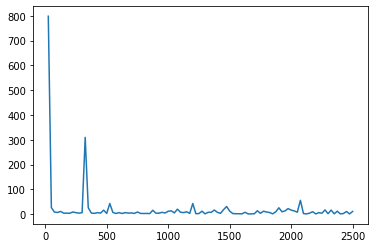

In [8]:
if __name__=='__main__':

    #load training_set
    folder_dataset = dset.ImageFolder(root=Config.training_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                            transform=transforms.Compose([transforms.Resize((160,60)),
                                                                          transforms.ToTensor()]))
    train_dataloader = DataLoader(siamese_dataset,
                                  shuffle=True,
                                  num_workers=0,
                                  batch_size=Config.train_batch_size)
    
    net = SiameseNetwork()
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(),lr = 0.0003)

    count = []
    loss_history = [] 
    iteration_number= 0

    #weight for global and local input. 0.9 performs well by parameter tuning.
    a = 0.9

    #training process
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0_hsv, img1_hsv, img0_grad, img1_grad, label = data
            optimizer.zero_grad()
        
            #HSV input & output, and grad input & output. Combine them to calculate loss.
            output0_hsv,output1_hsv = net(img0_hsv,img1_hsv)
            output0_grad,output1_grad = net(img0_grad,img1_grad)
            output0 = torch.cat((a*output0_hsv, (1-a)*output0_grad), 1)
            output1 = torch.cat((a*output1_hsv, (1-a)*output1_grad), 1)        
            loss = criterion(output0,output1,label)
            loss.backward()
            optimizer.step()
        
            #every epoch has 25 paris
            if i %25 == 0 :
                iteration_number +=25
                print("Epoch {} loss: {}".format(epoch,loss.item()))
                count.append(iteration_number)
                loss_history.append(loss.item())
    plt.plot(count,loss_history)
    plt.show()
    
    #save model
    state = {"net":net.state_dict()}
    save_p = "./net_test.pth"
    torch.save(state, save_p)